<a href="https://colab.research.google.com/github/sentimentalhoon/python_colab/blob/main/ex04_mlp_%ED%99%9C%EC%84%B1%ED%99%94%EC%82%BC%EC%88%98_%EC%B5%9C%EC%A0%81%ED%99%94%ED%95%A8%EC%88%98%EB%B9%84%EA%B5%90_%ED%8C%A8%EC%85%98%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# 런타임 > 런타임 유형 변경 > GPU 연결
# 드라이브 연동
# 딥러닝 폴더 경로 이동!
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning_AI2(202310)

/content/drive/MyDrive/Colab Notebooks/DeepLearning_AI2(202310)


### 목표
- 이미지 형태의 데이터를 이해
- 활성화 함수, 최적화 함수 비교
- 최적의 모델을 저장, 조기학습 중단 연결
- 저장된 모델 불러와 사용

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# 데이터 불러오기 - 패션 아이템 이미지 데이터
from tensorflow.keras.datasets import fashion_mnist

In [35]:
data = fashion_mnist.load_data()


In [36]:
print(len(data))
print(type(data))
print(len(data[0]), type(data[0]))
print(len(data[1]), type(data[1]))

2
<class 'tuple'>
2 <class 'tuple'>
2 <class 'tuple'>


In [37]:
data[0]
# (X_train, y_train) : (3차원 배열, 1차원)
data[1]
# (X_test, y_test) : (3차원 배열, 1차원)

# data = ((X_train, y_train), (X_test, y_test))

X_train, y_train = data[0]
X_test, y_test = data[1]


In [38]:
# 크기 확인
print(f'{X_train.shape} {y_train.shape}')
print(f'{X_test.shape} {y_test.shape}')

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [39]:
# 변수명 4개를 미리 지정해 데이터를 담아주는 방법 ( 언패킹 활용)
(X_train, y_train), (X_test, y_test) = data
print(f'{X_train.shape} {y_train.shape}')
print(f'{X_test.shape} {y_test.shape}')

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


(28, 28)
255
0


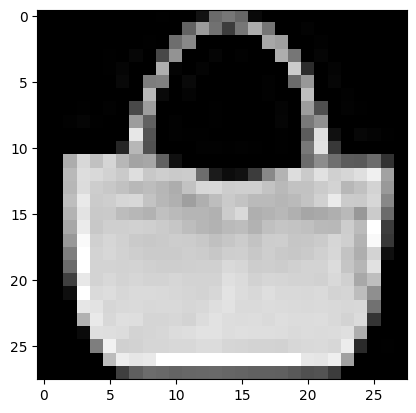

In [40]:
# 이미지 출력해보기
# X_train 10-번째 인덱스에 해당하는 이미지 접근
img100 = X_train[100]
print(img100.shape)
print(img100.max())
print(img100.min())
#0~255 표현된 이미지
# 0 : 검은색, 255 : 흰색
# 이미지 1장이 2차원으로 표현 -> 흑백 계열의 이미지
plt.imshow(img100, cmap='gray')
plt.show()


In [41]:
# y_train 답 데이터 100번째 확인
y_train[100]

8

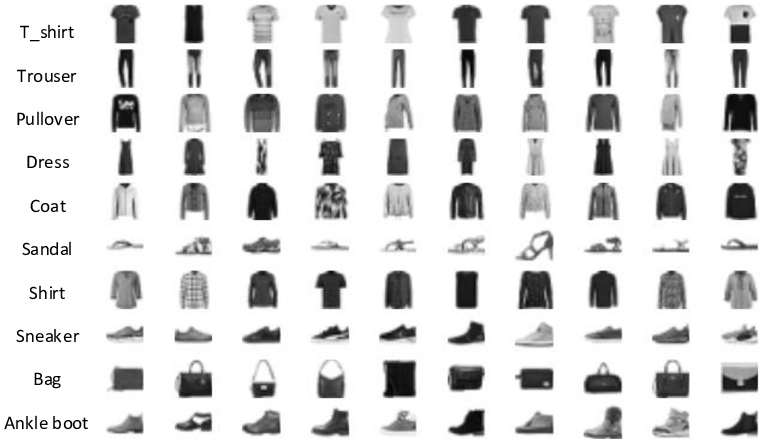

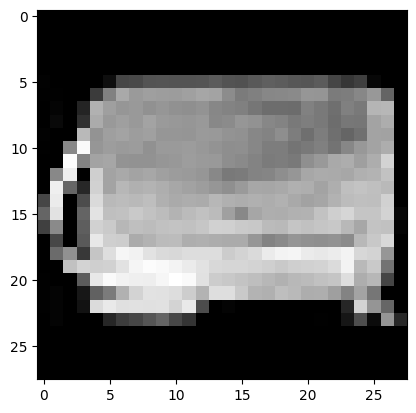

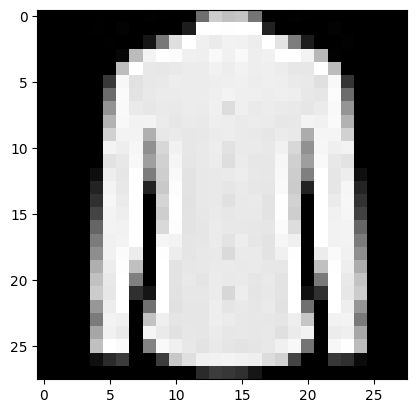

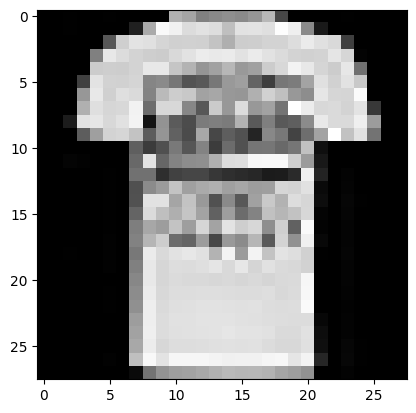

In [42]:
# random_list = np.random.randin(len(X_train), size=30)
import random
for i in range(3):
  j = random.randint(0, len(X_train))
  plt.imshow(X_train[j], cmap='gray')
  plt.show()

In [43]:
# y_train
# 답데이터의 카테고리 개수는 몇개인가

# 마지막 출력층 유닛 개수를 결정
print(np.unique(y_train).size)

# 각각 몇개씩 들어있는가
print(np.unique(y_train, return_counts=True))

10
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [46]:
# 다중분류 답데이터 전처리
# 원핫인코딩
# pd -> get_dummies()
# keras -> to_categorical()
from tensorflow.keras.utils import to_categorical
# Returns
# DataFrame
#    Dummy-coded data.
y_train_oh = pd.get_dummies(y_train)
# Returns: A binary matrix representation of the input as a NumPy array. The class axis is placed last.
y_test_oh = to_categorical(y_test)

In [52]:
# 문제 데이터 전처리
# mlp 1차원만 인식 가능
# 이미지 1장 2차원 > 1차원
X_train2 = X_train.reshape(len(X_train), X_train[0].shape[0] * X_train[0].shape[1])
X_test2 = X_test.reshape(len(X_test), X_test[0].shape[0] * X_test[0].shape[1])

# 크기 확인
print(f'훈련 확인 : {X_train2.shape}')
print(f'테스트 확인 : {X_test2.shape}')
# 이미지 1장은 1차원, 784개의 특성이 존재

훈련 확인 : (60000, 784)
테스트 확인 : (10000, 784)


#### 활성화 함수, 최적화 함수별 비교
- 1. 중간층 활성화 : sigmoid, 최적화함수 sgd
- 2. 중간층 활성화 : relu, 최적화 함수 sgd
- 3. 중간층 활성화 : relu, 최적화 함수 adam
  - 각 신경망을 설계하고 결과를 비교해보자

In [53]:
# optimizer import
from tensorflow.keras.optimizers import SGD, Adam


In [54]:
# 모델 생성 함수를 정의
# 활성화 함수, 최적화 함수 매개변수로 연결
def create_model(acti, opti):
  # 모델 생성
  model = Sequential()
  # 입력층, 중간층 1개 (200)
  model.add(Dense(units=200, input_dim=28*28, activation=acti))
  # 중간층 2개 (100, 50)
  model.add(Dense(units=100, activation=acti))
  model.add(Dense(units=50, activation=acti))
  # 출력층 (클래스 개수만큼, 활성화 = 'softmax')
  model.add(Dense(units=10, activation='softmax'))
  # 학습/평가 방법 설정 (compile)
  # loss, optimizer, metrics=['acc']
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opti,
      metrics=['accuracy'] # 분류 평가 지표
  )
  model.summary()
  # 반환 model
  return model

In [55]:
# fit 함수 정의
# estimator : 예측기
# 모델명만 넣어주면 fit 진행하는 함수
def fit_model(estimator):
  # 학습 코드 : 30 정도 반복, 문제 데이터, 답 데이터, 검증 데이터(train 데이터 분리)
  h = estimator.fit(
      X_train2,
      y_train_oh,
      validation_split=0.3, # 30% 검증용
      # validation_data=(X_val, y_val)
      epochs=30
      )
  # return 학습 현황
  return h

In [ ]:
# 1. sig + sgd
# 학습률 조정하고 싶다면 SGD 불러서 변경 가능
# SGD(learning_rate=0.01)
model1 = create_model(acti='sigmoid', opti=SGD(learning_rate=0.01))
h1 = fit_model(model1)

In [ ]:
# 2. relu + sgd ( 0.01 )
# 학습률 조정하고 싶다면 SGD 불러서 변경 가능
# SGD(learning_rate=0.01)
model2 = create_model(acti='relu', opti=SGD(learning_rate=0.01))
h2 = fit_model(model2)

In [61]:
# 3. model : 'relu' + Adam(learning-rate=0.001)
model3 = create_model(acti='relu', opti=Adam(learning_rate=0.001))
h3 = fit_model(model3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 200)               157000    
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 10)                510       
                                                                 
Total params: 182660 (713.52 KB)
Trainable params: 182660 (713.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1313/1313 [==============================] - 8s 5ms/step - loss: 1.8485 - accuracy: 0.7423 - val_loss: 0.5818 - val_accuracy: 0.8064
Ep

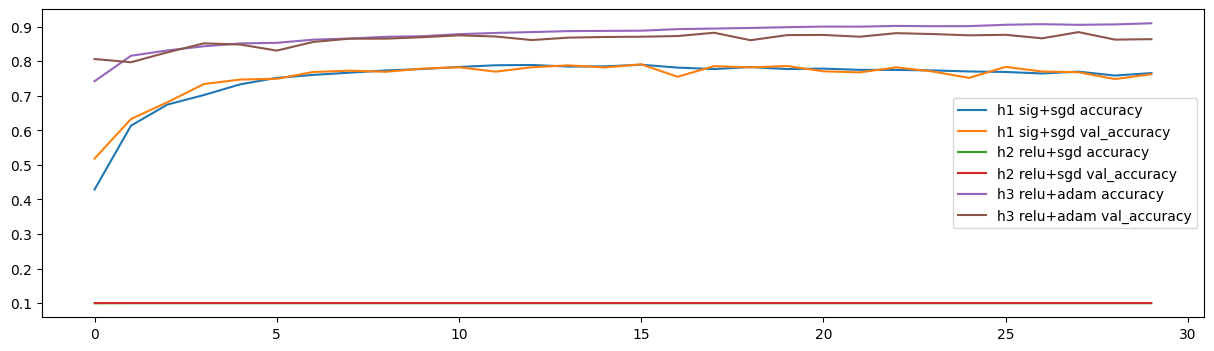

In [66]:
plt.figure(figsize=(15, 4))

accuracy = h1.history['accuracy']
val_accuracy = h1.history['val_accuracy']

plt.plot(accuracy, label='h1 sig+sgd accuracy')
plt.plot(val_accuracy, label='h1 sig+sgd val_accuracy')

accuracy = h2.history['accuracy']
val_accuracy = h2.history['val_accuracy']

plt.plot(accuracy, label='h2 relu+sgd accuracy')
plt.plot(val_accuracy, label='h2 relu+sgd val_accuracy')

accuracy = h3.history['accuracy']
val_accuracy = h3.history['val_accuracy']

plt.plot(accuracy, label='h3 relu+adam accuracy')
plt.plot(val_accuracy, label='h3 relu+adam val_accuracy')

plt.legend()
plt.show()